 ##### Ejemplos prácticos Data Science - Agustina Torres Moray.

## SERIES DE TIEMPO

### REGRESIÓN LINEAL / TRANSFORMACION LOGARÍTMICA / DUMMIES ESTACIONALES

#### Dataset

Trabajaremos con el dataset adjunto sobre precios de la cebolla en la India.

El dataset tiene tres columnas (features o variables) sobre la ubicación del mercado mayorista donde se vendió cebolla:

* **state**: esta es la abreviatura de 2/3 letras para el estado en India (PB es Punjab, etc.)
* **ciudad**: esta es la ciudad en India (ABOHAR, BANGALORE y así sucesivamente)
* **mercado**: esta es una cadena con la combinación del estado y la ciudad

Tres están relacionados con la fecha de la transacción: 

* **mes**: mes en enero, febrero y así sucesivamente
* **año**: año (YYYY)
* **fecha**: la combinación de los dos anteriores

Cuatro son acerca de la cantidad y el precio en este mercado mayorista (todas numéricas).

* **cantidad**: la cantidad de cebolla que llega al mercado en ese mes en quintales (100 kg)
* **priceMin**: el precio mínimo en el mes en Rs./quintal
* **priceMax**: el precio máximo en el mes en Rs./quintal
* **priceMod**: el precio modal en el mes en Rs./quintal


#### Objetivo:

Generar un modelo temporal que prediga el precio de la cebolla en la India en un determinado instante de tiempo.

### DESARROLLO

#### 1 - Importar librerías necesarias.

In [466]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

#### 2 - Preproccesamiento - generación de variables dummies

In [467]:
df = pd.read_csv("cebolla_india.csv")
df.shape

(10227, 10)

In [468]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,January-2005
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,January-2006
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,January-2010
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,January-2011
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,January-2012


In [469]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10227 entries, 0 to 10226
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   market    10227 non-null  object
 1   month     10227 non-null  object
 2   year      10227 non-null  int64 
 3   quantity  10227 non-null  int64 
 4   priceMin  10227 non-null  int64 
 5   priceMax  10227 non-null  int64 
 6   priceMod  10227 non-null  int64 
 7   state     10227 non-null  object
 8   city      10227 non-null  object
 9   date      10227 non-null  object
dtypes: int64(5), object(5)
memory usage: 799.1+ KB


Transformamos el campo "date" al tipo de variable correspondiente : fecha.

In [470]:
df["date"] = pd.to_datetime(df["date"])

In [471]:
df["date"].dtypes

dtype('<M8[ns]')

Agrupamos y analizamos la cantidad de ventas por ciudad.

In [472]:
df.groupby("city")["quantity"].sum().sort_values(ascending=False).head()

city
BANGALORE     76491944
PUNE          59470570
LASALGAON     58765209
PIMPALGAON    53231396
DELHI         46305615
Name: quantity, dtype: int64

Vamos a considerar para el análisis únicamente la ciudad de BANGALORE

In [473]:
dfBang = df.loc[df.city == "BANGALORE"].copy()
dfBang = dfBang.sort_values(by="date")

In [474]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
716,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
729,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
742,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
754,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
766,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


Reindexamos el dataframe para el index este definido por la fecha mensual.

In [475]:
dfBang.index = pd.PeriodIndex(dfBang.date, freq="M")

In [476]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01


Creamos una función que plotea series de tiempo

In [477]:
def plot_df(df,x,y,title="", xlabel="Fecha", ylabel="Valor",dpi=100):
    plt.figure(figsize=(16,5),dpi=dpi)
    plt.plot(x,y,color="tab:red")
    plt.gca().set(title=title,xlabel=xlabel,ylabel=ylabel)
    plt.show()

Continuamos trabajando con la variable PriceMod, dejando de lado los precios Max y Min.

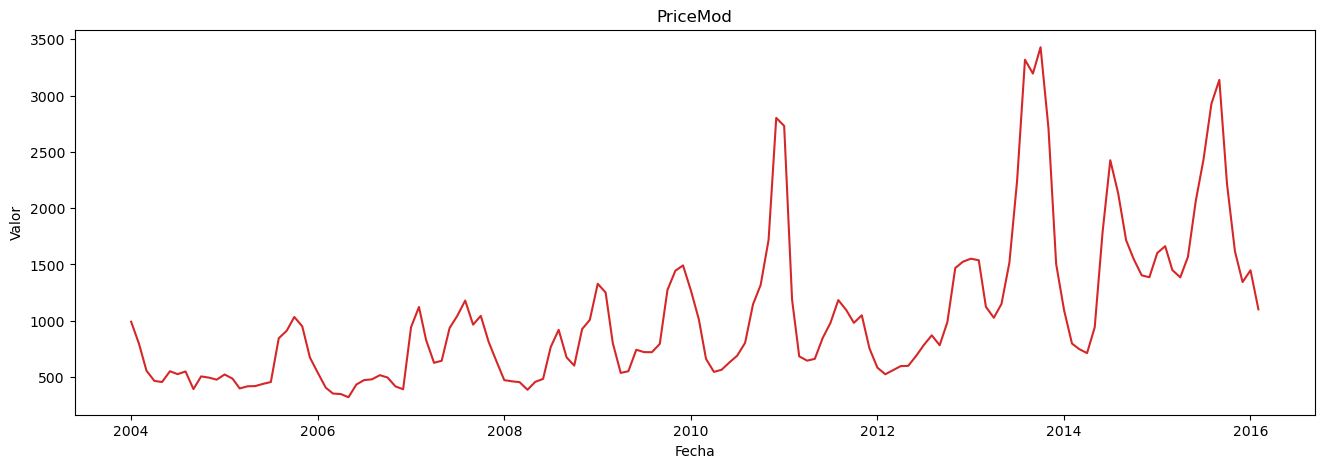

In [478]:
plot_df(dfBang,x=dfBang.date,y=dfBang.priceMod,title="PriceMod")

Creamos una dummy de tiempo para modelar la tendencia lineal.

In [479]:
dfBang["timeIndex"] = pd.Series(np.arange(len(dfBang["priceMod"])),index=dfBang.index)

In [480]:
dfBang.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,timeIndex
date,,,,,,,,,,,
2004-01,BANGALORE,January,2004,227832,916,1066,991,KNT,BANGALORE,2004-01-01,0
2004-02,BANGALORE,February,2004,225133,741,870,793,KNT,BANGALORE,2004-02-01,1
2004-03,BANGALORE,March,2004,221952,527,586,556,KNT,BANGALORE,2004-03-01,2
2004-04,BANGALORE,April,2004,185150,419,518,465,KNT,BANGALORE,2004-04-01,3
2004-05,BANGALORE,May,2004,137390,400,516,455,KNT,BANGALORE,2004-05-01,4


In [481]:
dfBang.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,timeIndex
date,,,,,,,,,,,
2015-10,BANGALORE,October,2015,1612160,385,3365,2215,KNT,BANGALORE,2015-10-01,141
2015-11,BANGALORE,November,2015,1071872,205,3138,1618,KNT,BANGALORE,2015-11-01,142
2015-12,BANGALORE,December,2015,513186,217,2030,1343,KNT,BANGALORE,2015-12-01,143
2016-01,BANGALORE,January,2016,507223,200,1943,1448,KNT,BANGALORE,2016-01-01,144
2016-02,BANGALORE,February,2016,400359,200,1505,1101,KNT,BANGALORE,2016-02-01,145


Creamos las dummies mensuales para modelar la estacionalidad.

In [482]:
dummies_mes = pd.get_dummies(dfBang["month"],drop_first=True)
dfBang = dfBang.join(dummies_mes)
dfBang.sample(10)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2014-06,BANGALORE,June,2014,496447,621,2296,1791,KNT,BANGALORE,2014-06-01,...,0,0,0,0,1,0,0,0,0,0
2011-09,BANGALORE,September,2011,713765,488,1427,1095,KNT,BANGALORE,2011-09-01,...,0,0,0,0,0,0,0,0,0,1
2007-07,BANGALORE,July,2007,212955,925,1173,1043,KNT,BANGALORE,2007-07-01,...,0,0,0,1,0,0,0,0,0,0
2007-10,BANGALORE,October,2007,1437923,409,1323,1043,KNT,BANGALORE,2007-10-01,...,0,0,0,0,0,0,0,0,1,0
2009-07,BANGALORE,July,2009,335728,512,886,721,KNT,BANGALORE,2009-07-01,...,0,0,0,1,0,0,0,0,0,0
2009-01,BANGALORE,January,2009,374380,848,1554,1328,KNT,BANGALORE,2009-01-01,...,0,0,1,0,0,0,0,0,0,0
2014-02,BANGALORE,February,2014,522132,296,1017,797,KNT,BANGALORE,2014-02-01,...,0,1,0,0,0,0,0,0,0,0
2005-01,BANGALORE,January,2005,335679,470,597,522,KNT,BANGALORE,2005-01-01,...,0,0,1,0,0,0,0,0,0,0
2004-11,BANGALORE,November,2004,724140,433,553,494,KNT,BANGALORE,2004-11-01,...,0,0,0,0,0,0,0,1,0,0


Separamos las matrices de train y test, reservando los últimos 12 meses para el testeo.

In [483]:
df_train,df_test = train_test_split(dfBang, test_size=12,random_state=42,shuffle=False)

Corroboramos la continuidad entre el set de entrenamiento y el de testeo.

In [484]:
df_train.tail()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2014-10,BANGALORE,October,2014,1412686,605,2037,1546,KNT,BANGALORE,2014-10-01,...,0,0,0,0,0,0,0,0,1,0
2014-11,BANGALORE,November,2014,1235389,145,2309,1403,KNT,BANGALORE,2014-11-01,...,0,0,0,0,0,0,0,1,0,0
2014-12,BANGALORE,December,2014,842653,312,2212,1386,KNT,BANGALORE,2014-12-01,...,1,0,0,0,0,0,0,0,0,0
2015-01,BANGALORE,January,2015,583681,313,1967,1602,KNT,BANGALORE,2015-01-01,...,0,0,1,0,0,0,0,0,0,0
2015-02,BANGALORE,February,2015,405716,609,2018,1662,KNT,BANGALORE,2015-02-01,...,0,1,0,0,0,0,0,0,0,0


In [485]:
df_test.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date,...,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,,,,,,,,
2015-03,BANGALORE,March,2015,443687,638,1660,1450,KNT,BANGALORE,2015-03-01,...,0,0,0,0,0,1,0,0,0,0
2015-04,BANGALORE,April,2015,468522,552,1564,1385,KNT,BANGALORE,2015-04-01,...,0,0,0,0,0,0,0,0,0,0
2015-05,BANGALORE,May,2015,420072,413,1904,1567,KNT,BANGALORE,2015-05-01,...,0,0,0,0,0,0,1,0,0,0
2015-06,BANGALORE,June,2015,485652,940,2356,2068,KNT,BANGALORE,2015-06-01,...,0,0,0,0,1,0,0,0,0,0
2015-07,BANGALORE,July,2015,505717,1192,2800,2432,KNT,BANGALORE,2015-07-01,...,0,0,0,1,0,0,0,0,0,0


#### 3 - Generación de modelos 

##### 3.1 - TENDENCIA LINEAL SIN Y CON TRANSFORMACIÓN LOGARÍTMICA (SIN ESTACIONALIDAD)

Creamos las transformaciones logarítmicas de priceMod para el set de entrenamiento y testeo.

In [486]:
df_train["log_value"] = np.log(df_train["priceMod"])
df_test["log_value"] = np.log(df_test["priceMod"])

SERIE LOGARÍTMICA - TRAIN

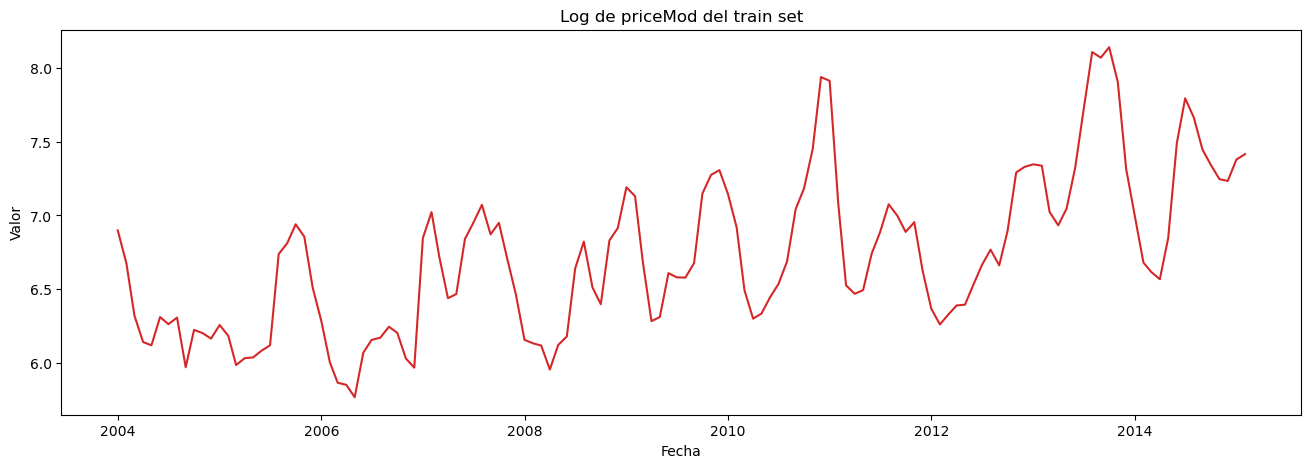

In [487]:
plot_df(df_train, x=df_train.date, y=df_train["log_value"],title="Log de priceMod del train set")

Entrenamos el modelo entre la serie tranformada y la dummy de tiempo creada previamente.

In [488]:
model_log = smf.ols('log_value ~ timeIndex', data = df_train).fit()

In [489]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     97.58
Date:                Tue, 26 Sep 2023   Prob (F-statistic):           1.44e-17
Time:                        09:32:15   Log-Likelihood:                -67.913
No. Observations:                 134   AIC:                             139.8
Df Residuals:                     132   BIC:                             145.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1280      0.070     88.132      0.000       5.990       6.266
timeIndex      0.0089      0.001      9.878      0.000       0.007       0.011
==============================================================================
Omnibus:                        5.041   Durbin-Watson:                   0.385
Prob(Omnibus):                  0.080   Jarque-Bera (JB):                5.129
Skew:                           0.455   Prob(JB):                       0.0770
Kurtosis:                       2.702   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

PREDICCIONES PARA TRAIN Y TEST- SIN BACK TRANSFORMATION

In [490]:
df_train["model_log"] = model_log.predict(df_train[["timeIndex"]])
df_test["model_log"] = model_log.predict(df_test[["timeIndex"]])

<AxesSubplot:xlabel='date'>

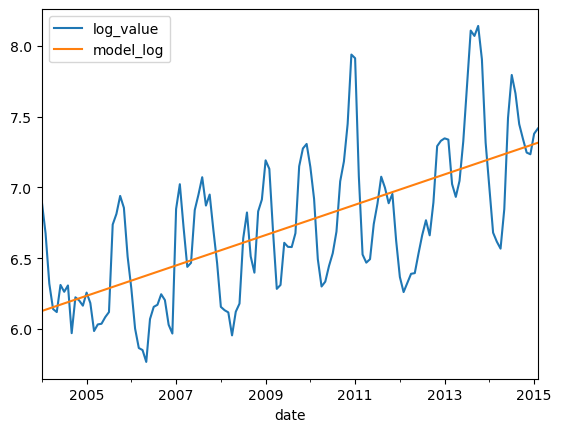

In [491]:
df_train.plot(kind="line", x= "date", y= ['log_value','model_log'])

<AxesSubplot:xlabel='date'>

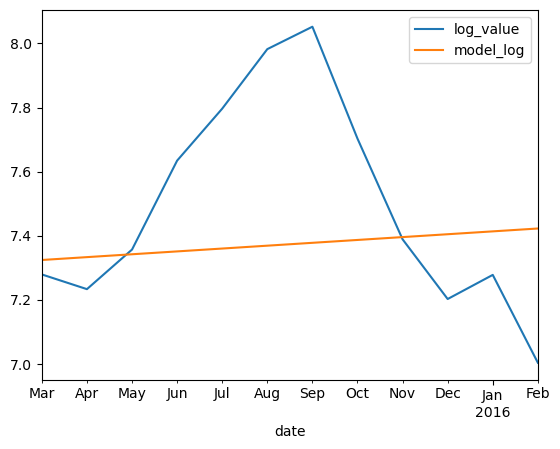

In [492]:
df_test.plot(kind="line", x= "date", y= ['log_value','model_log'])

PREDICCIONES PARA TRAIN Y TEST - CON BACK TRASNFORMATION

In [493]:
df_train["back_model_log"] = np.exp(df_train["model_log"])
df_test["back_model_log"] = np.exp (df_test["model_log"])

<AxesSubplot:xlabel='date'>

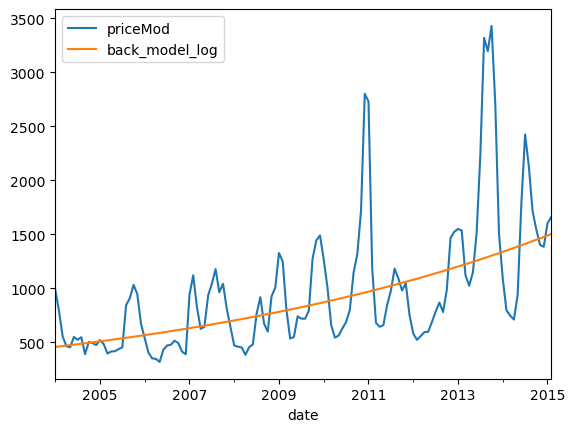

In [494]:
df_train.plot(kind="line", x="date", y = ["priceMod", "back_model_log"])

<AxesSubplot:xlabel='date'>

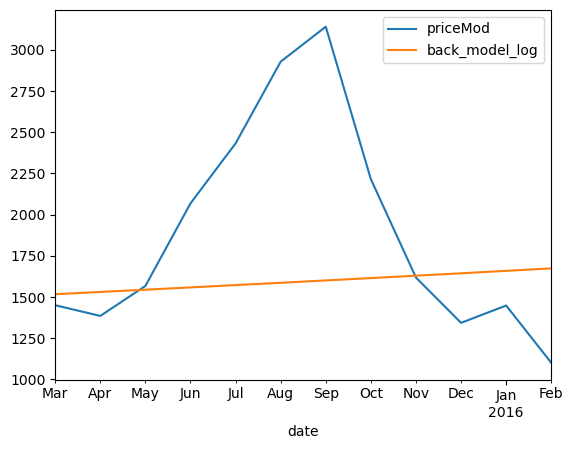

In [495]:
df_test.plot(kind="line", x="date", y = ["priceMod", "back_model_log"])

Creamos una función para calcular el Error Cuadrático Medio (RMSE)

In [496]:
def RMSE (predicted,actual):
    mse=(predicted-actual)**2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

Guardamos el resultado en un dataframe:

In [497]:
df_Results = pd.DataFrame(columns=["Model","RMSE"])
df_Results.loc[0,"Model"] = "Log"
df_Results.loc[0,"RMSE"] = RMSE(df_test.back_model_log, df_test.priceMod)
df_Results

,Model,RMSE
0,Log,708.283


##### 3.2 - TENDENCIA CON TRANSF. LOG. Y ESTACIONALIDAD 

In [498]:
model_log_est = smf.ols('log_value  ~ timeIndex + August + December + February +January + July + November + October + September + June + March + May', data = df_train).fit()

In [499]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     13.91
Date:                Tue, 26 Sep 2023   Prob (F-statistic):           9.99e-18
Time:                        09:32:16   Log-Likelihood:                -46.915
No. Observations:                 134   AIC:                             119.8
Df Residuals:                     121   BIC:                             157.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.7628      0.120     47.907      0.000       5.525       6.001
timeIndex      0.0086      0.001     10.663      0.000       0.007       0.010
August         0.5681      0.154      3.686      0.000       0.263       0.873
December       0.5134      0.154      3.329      0.001       0.208       0.819
February       0.3963      0.151      2.626      0.010       0.098       0.695
January        0.5668      0.151      3.757      0.000       0.268       0.866
July           0.4231      0.154      2.745      0.007       0.118       0.728
November       0.6098      0.154      3.954      0.000       0.304       0.915
October        0.5800      0.154      3.762      0.000       0.275       0.885
September      0.4973      0.154      3.226      0.002       0.192       0.803
June           0.2795      0.154      1.814      0.072      -0.026       0.585
March          0.1282      0.154      0.832      0.407      -0.177       0.433
May            0.0439      0.154      0.285      0.776      -0.261       0.349
==============================================================================
Omnibus:                        2.832   Durbin-Watson:                   0.364
Prob(Omnibus):                  0.243   Jarque-Bera (JB):                2.846
Skew:                           0.344   Prob(JB):                        0.241
Kurtosis:                       2.808   Cond. No.                         965.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Entrenamos nuevamente el modelo sin los meses de Junio, Marzo y Mayo (no significativos)

In [500]:
model_log_est = smf.ols('log_value  ~ timeIndex + August + December + February +January + July + November + October + September ', data = df_train).fit()

PREDICCIONES EN TRAIN Y TEST SIN BACK TRANSFORMATION

In [501]:
df_train ["model_log_est"] = model_log_est.predict(df_train[["timeIndex","August", "December", "February", "January", "July","November", "October", "September" ]])

In [502]:
df_test ["model_log_est"] = model_log_est.predict(df_test[["timeIndex","August", "December", "February", "January", "July","November", "October", "September" ]])

<AxesSubplot:xlabel='date'>

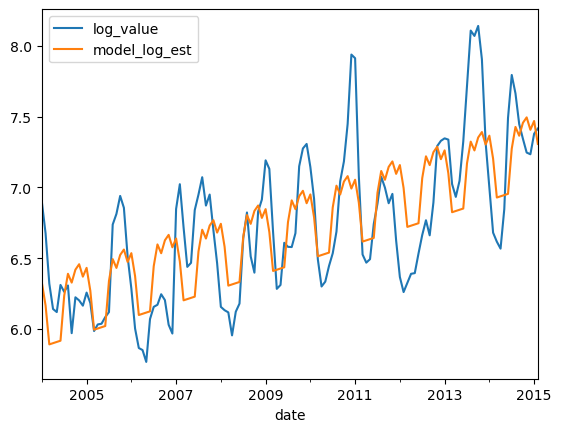

In [503]:
df_train.plot(kind="line", x="date", y=["log_value","model_log_est"])

<AxesSubplot:xlabel='date'>

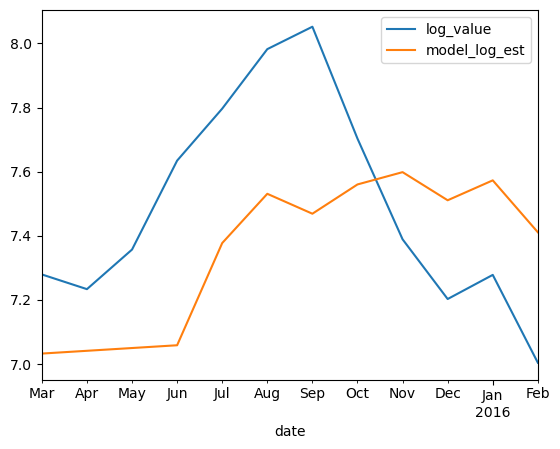

In [504]:
df_test.plot(kind="line", x="date", y=["log_value","model_log_est"])

PREDICCIONES EN TRAIN Y TEST - CON BACK TRANSFORMATION

In [505]:
df_train["back_model_log_est"] = np.exp(df_train["model_log_est"])
df_test["back_model_log_est"] = np.exp(df_test["model_log_est"])

<AxesSubplot:xlabel='date'>

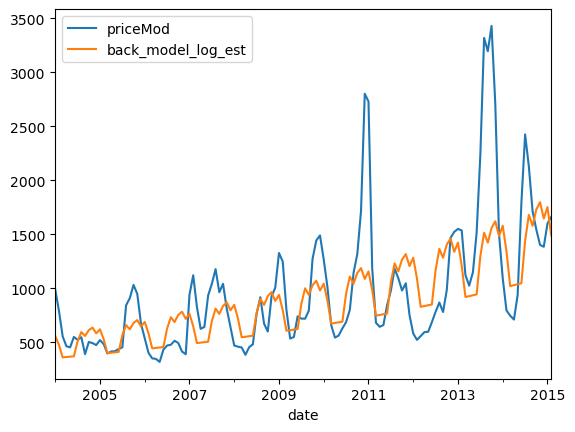

In [506]:
df_train.plot(kind="line", x="date", y=["priceMod","back_model_log_est"])

<AxesSubplot:xlabel='date'>

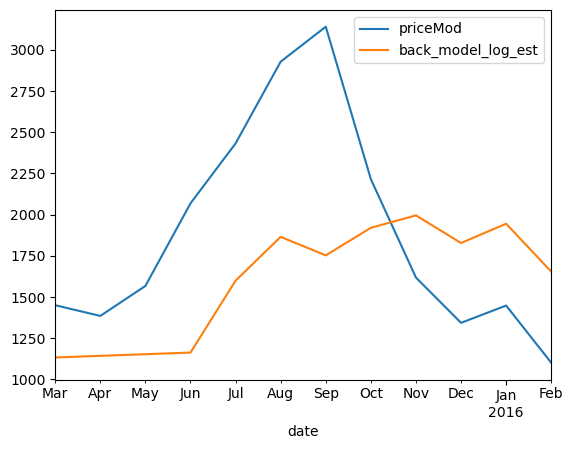

In [507]:
df_test.plot(kind="line", x="date", y=["priceMod","back_model_log_est"])

Calculamos el RMSE para este caso:

In [508]:
df_Results.loc[1,"Model"] = "Log + Est."
df_Results.loc[1, "RMSE"] = RMSE(df_test.back_model_log_est, df_test.priceMod)

In [509]:
df_Results

,Model,RMSE
0,Log,708.283
1,Log + Est.,702.169


##### 3.3 - MODELO ARIMA

Calculamos el residuo del último modelo (Log + Est.) e intentaremos modelar la variable cíclica a traves de ARIMA, siempre y cuando la serie obtenida sea ESTACIONARIA.

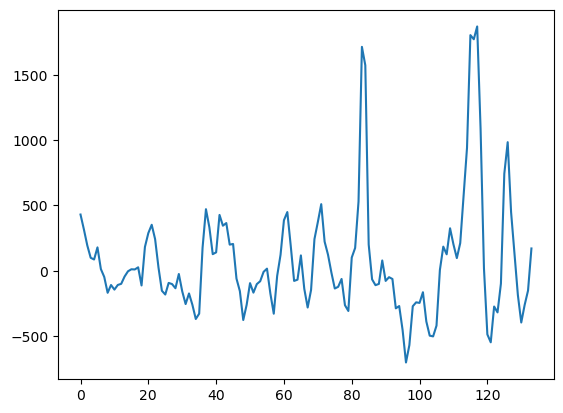

In [510]:
residuo = df_train["priceMod"] - df_train["back_model_log_est"]
plt.plot(df_train.timeIndex, residuo)

Para verificar si es serie estacionaria, aplicamos el Test de D.Fuller:

In [511]:
dfuller = adfuller(residuo)
print("ADF Statistic: %f" % dfuller[0])
print("p-value: %f" % dfuller[1])


ADF Statistic: -5.399323
p-value: 0.000003


Como el p-value es MENOR a 0.05, podemos verificar que se trata de una serie estacionaria.

Para modelar ARIMA, necesitamos los parámetros p y q, los que obtenemos de las gráficas: ACF Y PACF.
Creamos una función que sea capaz de plotear la serie y darnos la iformación necesaria.

In [512]:
def tsplot(y, lags = None, figsize = (12,7), style= "bmh"):

    if not isinstance(y,pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)

        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax)

        p_value = sm.tsa.stattools.adfuller(y)[1]

        ts_ax.set_title("Analisis de la serie de tiempo\n Dickey Fuller: p = {0: .5f}"\
                        .format(p_value))
        
        smt.graphics.plot_acf(y,lags = lags, ax=acf_ax)
        smt.graphics.plot_pacf(y,lags = lags, ax=pacf_ax)
        plt.tight_layout()


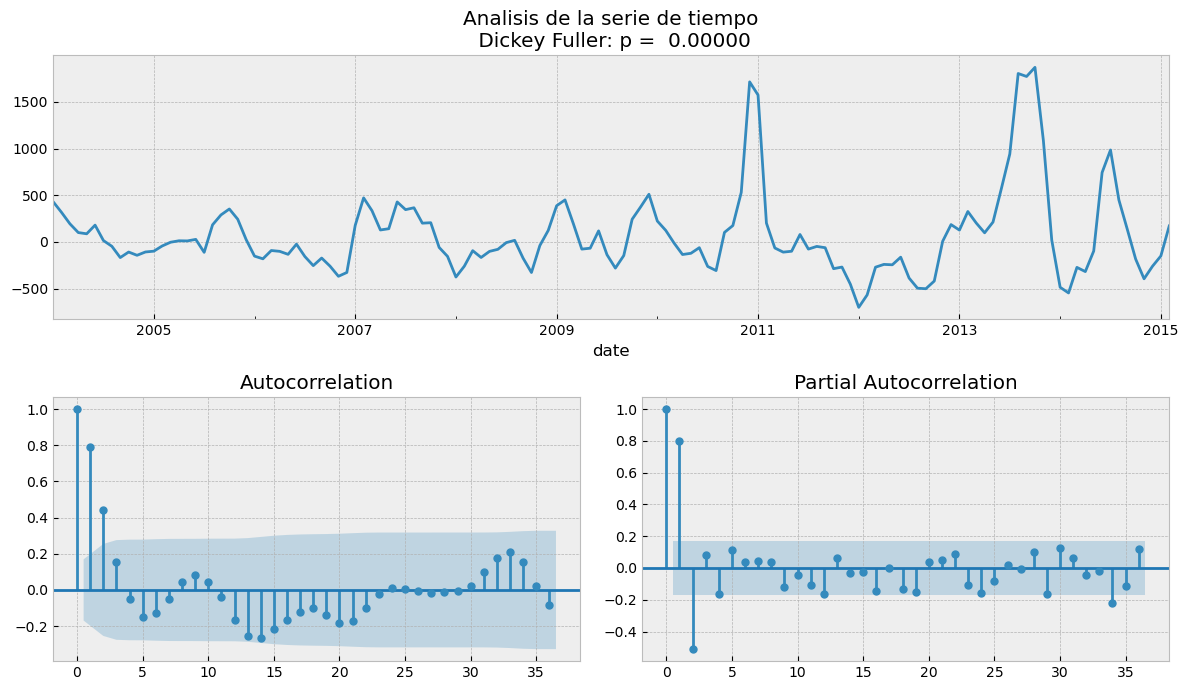

In [513]:
tsplot ( residuo, lags = 36)

De las gráficas podemos observar y concluir: 
    - La serie ya es estacionaria, por lo que no es necesario diferenciarla (d=0)
    - La funcion de autocorrelacion ACF cae en forma exponencial, lo que sugiere que la componente de medias móviles es un MA(0), por lo tanto q=0.
    - La funcion PACF tiene dos picos significativamente diferentes a cero, lo que sugiere que la componente autoregresiva es un AR(2), por lo tanto p=2.

In [514]:
model_ARIMA = ARIMA(residuo, order = (2,0,0)) 

In [515]:
results_ARIMA = model_ARIMA.fit()

In [516]:
results_ARIMA.fittedvalues.head()

date
2004-01     77.239323
2004-02    357.609553
2004-03    185.420858
2004-04     96.660078
2004-05     45.799450
Freq: M, dtype: float64

Graficamos la serie original (residuo) vs los datos entrenados.

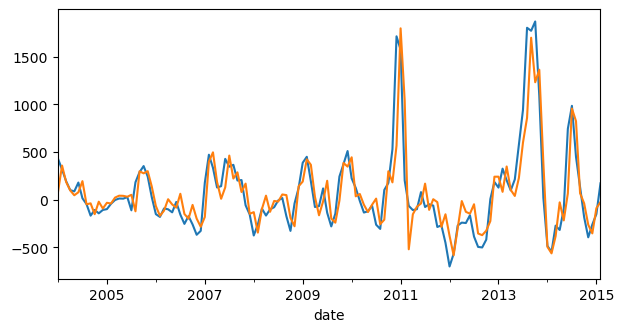

In [517]:
plt.figure(figsize=(7,3.5))
residuo.plot()
results_ARIMA.fittedvalues.plot();

Graficamos predicciones para un intervalo de confianza del 95%:

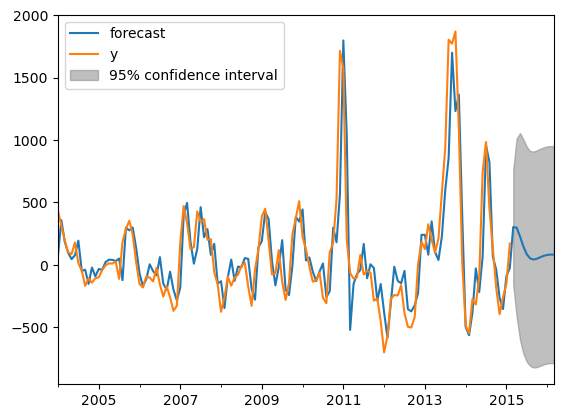

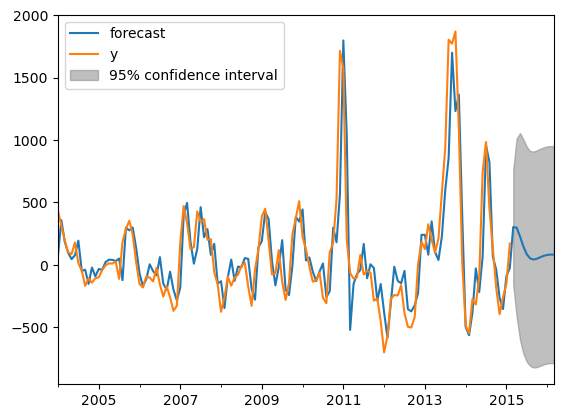

In [519]:
results_ARIMA.plot_predict(end = len(dfBang["priceMod"]))

Calculamos el residuo de ARIMA y graficamos la serie de tiempo obtenida.

In [520]:
res_ARIMA = results_ARIMA.fittedvalues - residuo

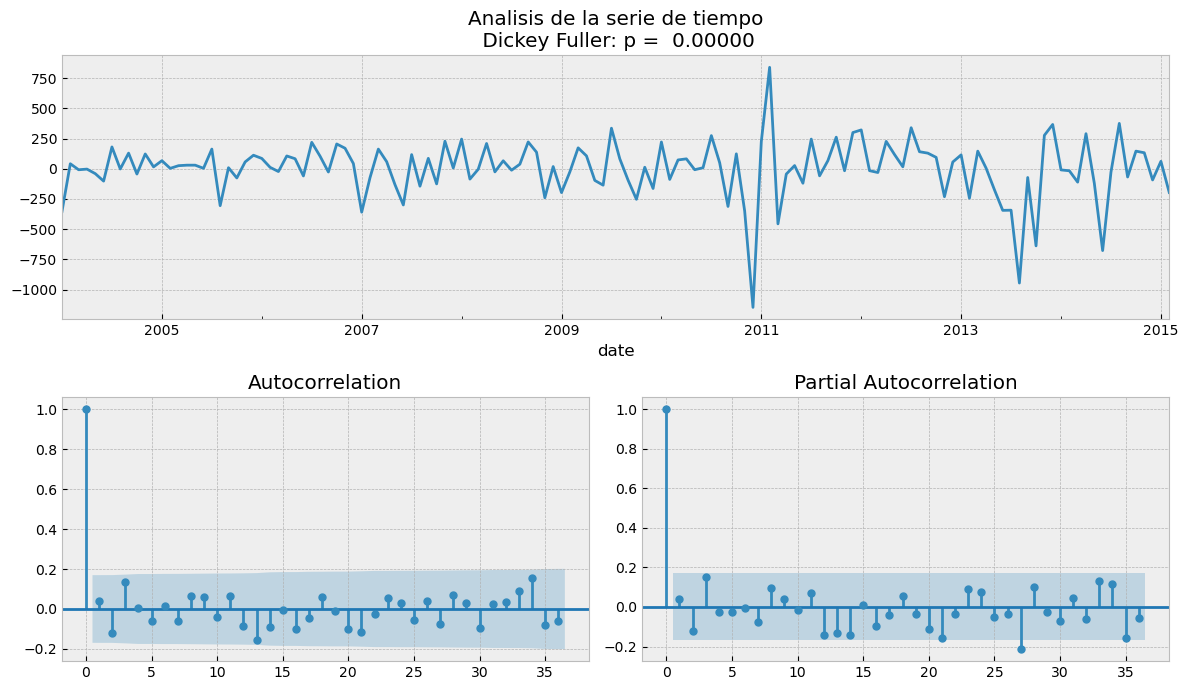

In [521]:
tsplot(res_ARIMA, lags = 36)

Como no encontramos valores significativamente diferentes a cero, en ACF ni en PACF, podemos concluir que lo que queda es RUIDO BLANCO.

Calculamos las predicciones en el set de testeo con el metodo generado:

In [522]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test["priceMod"]), alpha = 0.05 )

Agregamos a los dataframes de entrenamiento y testeo los modelos completos (tendencia,estacionalidad y ARIMA)

df_traing["model_ARIMA"] = df_train["back_model_log_est"] + results

In [523]:
df_train["model_ARIMA"] = df_train["back_model_log_est"] + results_ARIMA.fittedvalues
df_test["model_ARIMA"] = df_test["back_model_log_est"] + predictions_ARIMA

ARIMA - PREDICCIONES TRAIN

<AxesSubplot:xlabel='date'>

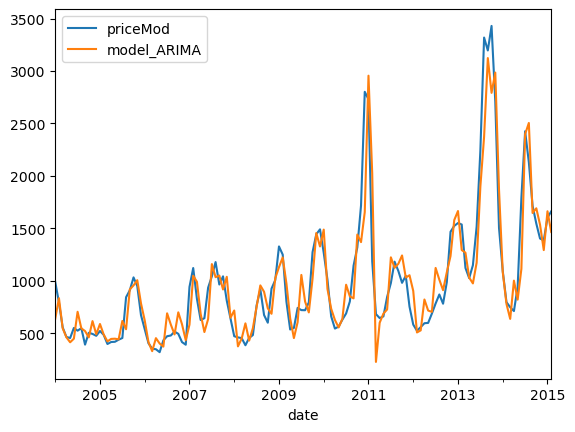

In [525]:
df_train.plot(kind="line", x="date", y=["priceMod", "model_ARIMA"])

ARIMA - PREDICCIONES EN TEST

<AxesSubplot:xlabel='date'>

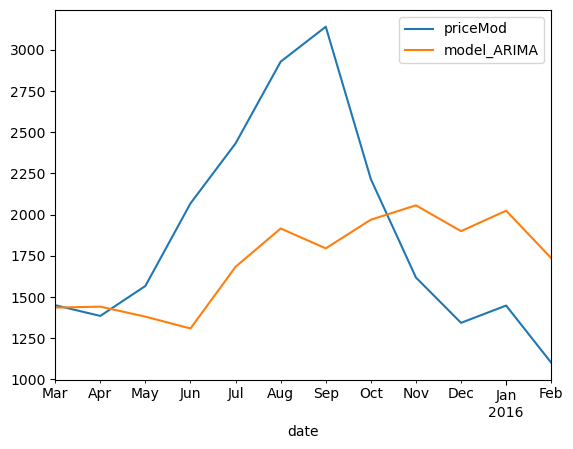

In [526]:
df_test.plot(kind="line", x="date", y=["priceMod", "model_ARIMA"])

Calculamos el RMSE y lo cargamos al dataframe de resultados 

In [527]:
df_Results.loc[2,"Model"] = "Log + Est + ARIMA"

In [528]:
df_Results.loc[2,"RMSE"] = RMSE(df_test["model_ARIMA"], df_test["priceMod"])
df_Results

,Model,RMSE
0,Log,708.283
1,Log + Est.,702.169
2,Log + Est + ARIMA,664.936


#### 4 - Comparativa de modelos - PERFORMANCE

#### Conclusion:

El modelo que combina la tendencia, estacionalidad y ciclos (ARIMA) es el de mejor performance.